# Predição Inadimplência Cartão de Crédito

## Descrição dos dados

* *X1:* Quanto foi dado de crédito em dólar (individual e família) (montante de crédito concedido)
* *X2:* Gênero -> 1 = Masculino, 2 = Feminino
* *X3:* Educação -> 1 = Pós-Graduação, 2 = Universidade, 3 = Ensino Médio, 4 = Outros
* *X4:* Estado Civil -> 1 = Casado, 2 = Solteiro, 3 = Outros
* *X5:* Idade
* *X6 - X11:* Histórico de Pagamentos -> X6 = Setembro à X11 = Abril (PAY_...)
    * -1: Pagou devidamente
    *  1: Pagou com atraso de um mês
    *  2: Pagou com atraso de dois meses
    *  3: Pagou com atraso de três meses
    ...
    
* *X12 - X17:* Quantia de declaração de conta -> X12 = Setembro à X17 = Abril (BILL_AMT_...)
* *X18 -> X23:* Montante do pagamento anterior -> X18 = Setembro à X23 = Abril (PAY_AMT_...)
* *X24:* Se a pessoa pagou, variável de interesse -> 1 = Sim, 2 = Não

In [1]:
import pandas as pd
import numpy as np

df = pd.read_excel('default of credit card clients.xls')
labels = df.iloc[0].values
df = df.iloc[1:]

df = pd.get_dummies(df, columns=['X2', 'X3', 'X4'])

In [2]:
# Heatmap with original data
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()
df = df.astype(float)

plt.figure(figsize=(10, 10))
sns.heatmap(df.corr(), square=True, cmap='RdYlGn')

In [3]:
# Drop records with minimum data
df.drop(inplace=True, columns=['X3_0', 'X4_0', 'X3_5', 'X3_6', 'X15', 'X16', 'X17'])

# Substitute discrete values - Mode
for i in range(6, 12):
    x_idx = f'X{str(i)}'
    
    np_array = df[x_idx].values
    mode = pd.Series(np_array[np_array != 0]).mode()[0]
    
    df[x_idx].replace(-2, np.nan, inplace=True)
    df[x_idx].fillna(mode, inplace=True)

# # Substitute discrete values - Median
# for i in range(6, 12):
#     x_idx = f'X{str(i)}'
    
#     df[x_idx].replace(0, np.nan, inplace=True)
#     df[x_idx].fillna(df[x_idx].median(skipna=True), inplace=True)

# Substitute real values
for i in range(12, 24):
    if i not in [15, 16, 17]:
        x_idx = f'X{str(i)}'
        sum_value = pd.to_numeric(df[x_idx], errors='coerce').sum()
        amount = len(df[x_idx].nonzero()[0])
        mean = sum_value/amount

        df[x_idx].replace(0, mean, inplace=True)

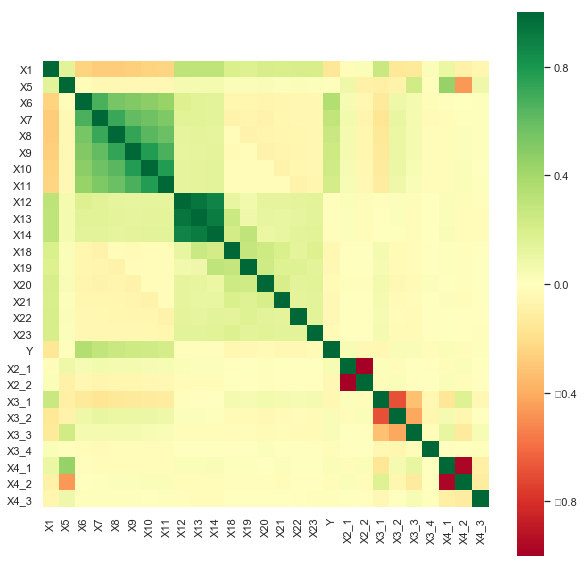

In [4]:
# Heatmap with sliced data
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()
df = df.astype(float)

plt.figure(figsize=(10, 10))
sns.heatmap(df.corr(), square=True, cmap='RdYlGn')

In [5]:
# Split training data and test data
from sklearn.model_selection import train_test_split

target = df['Y'].values
data = df.drop('Y', axis=1).values

X_train, X_test, y_train, y_test = train_test_split(
    data, target, test_size=0.35, random_state=42, stratify=target)

In [6]:
# Using KNN mathematical model to calculate performance.
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

print(classification_report(y_test, y_pred, target_names=['PAID', 'NOT PAID']))
print(knn.score(X_test, y_test))

              precision    recall  f1-score   support

        PAID       0.79      0.97      0.87      8177
    NOT PAID       0.48      0.09      0.16      2323

   micro avg       0.78      0.78      0.78     10500
   macro avg       0.63      0.53      0.51     10500
weighted avg       0.72      0.78      0.71     10500

0.776952380952381


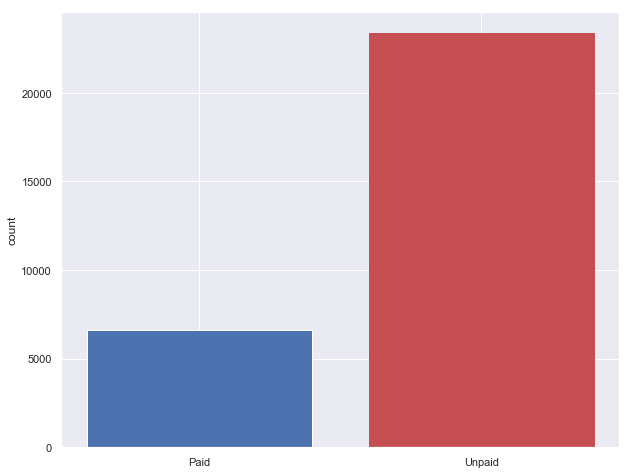

In [7]:
# Barplot of Y    
plt.figure(figsize=(10,8))
barlist = plt.bar(df.Y.unique(),df.Y.value_counts())
barlist[0].set_color('r')
plt.xticks(df.Y.unique(),('Unpaid','Paid'))
plt.ylabel('count')
plt.show()

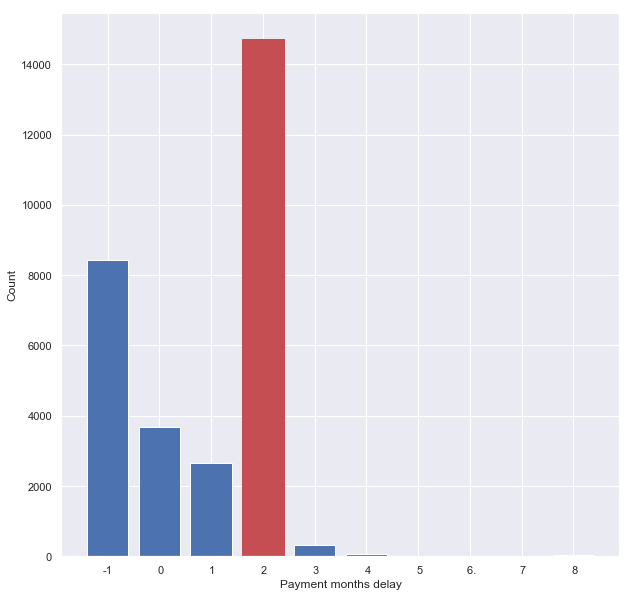

In [8]:
# Barplot of Payment History
plt.figure(figsize=(10,10))
barlist = plt.bar(df.X6.unique(),df.X6.value_counts())
barlist[0].set_color('r')
plt.xticks(df.X6.unique(),str(df.X6.unique()).replace('[', '').replace(']', '').split('. '))
plt.ylabel('Count')
plt.xlabel('Payment months delay')
plt.show()

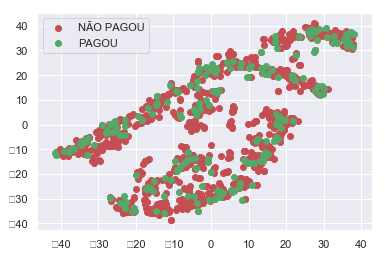

In [9]:
import pandas as pd
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

X = df.drop(['Y'],axis=1)
X = df.head(1000)

y = df['Y'].head(1000)
y = y.values

tsne = TSNE(n_components=2, random_state=0)

X_2d = tsne.fit_transform(X.values)
target_ids = range(len((df.Y.unique())))

colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'w', 'orange', 'purple'
for i, c, label in zip(target_ids, colors, ('NÃO PAGOU', 'PAGOU')):
    plt.scatter(X_2d[y == i, 0], X_2d[y == i, 1], c=c, label=label)
plt.legend()
plt.show()

In [10]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
    max_depth=1, random_state=0).fit(X_train, y_train)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred, target_names=['PAID', 'NOT PAID']))
print(clf.score(X_test, y_test))

              precision    recall  f1-score   support

        PAID       0.83      0.95      0.89      8177
    NOT PAID       0.65      0.34      0.45      2323

   micro avg       0.81      0.81      0.81     10500
   macro avg       0.74      0.64      0.67     10500
weighted avg       0.79      0.81      0.79     10500

0.8135238095238095


In [11]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver='lbfgs', alpha=1e-5,
                     hidden_layer_sizes=(5, 2), random_state=1)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred, target_names=['PAID', 'NOT PAID']))
print(clf.score(X_test, y_test))

              precision    recall  f1-score   support

        PAID       0.71      0.00      0.00      8177
    NOT PAID       0.22      1.00      0.36      2323

   micro avg       0.22      0.22      0.22     10500
   macro avg       0.47      0.50      0.18     10500
weighted avg       0.61      0.22      0.08     10500

0.2215238095238095
